<a href="https://colab.research.google.com/github/jo-cho/advances_in_financial_machine_learning/blob/master/meta_labeling_%26_bet_sizing_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

META-LABELING AND BET SIZING

This notebook is based on the book *Advances in Financial Machine Learning* by Lopez De Prado. (Chapter 3 and Chapter 10)

# IMPORT LIB

In [0]:
# lib
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [0]:
# sklearn

from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn import metrics

In [3]:
!pip install -q ta
import ta

In [0]:
import warnings
warnings.filterwarnings(action='ignore')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
# Big thanks to mlfinlab!

!pip install mlfinlab
from mlfinlab import data_structures, features, filters, labeling, util, sampling, cross_validation, structural_breaks, microstructural_features

     |████████████████████████████████| 163kB 31.3MB/s 


# 1. Bet sizing  applying meta-labeling

We fit a
classifier, such as an SVC or RF, to determine the probability of misclassification, and
use that probability to derive the bet size.

### WHY do we use meta-labeling for sizing the bet?

Advantages
1. The ML algorithm that decides the bet sizes is independent of the primary model, allowing for the incorporation of features predictive of false positives (meta-labeling - see below). 

2. The predicted probability can be directly translated into bet size.

### What is meta labeling?

Suppose that you have a model for setting the side of the bet (long or short). You just need to learn the size of that bet, which includes the possibility of no bet at all (zero size). This is a situation that practitioners face regularly. We often know whether we want to buy or sell a product, and the only remaining question is **how much money we should risk in such a bet**. We do not want the ML algorithm to learn the side, just
to tell us what is the **appropriate size**. We want to build a **secondary ML model** that learns how to use a primary exogenous model.

Binary classification problems present a trade-off between type-I errors (false positives) and type-II errors (false negatives). In general, increasing the true positive rate of a binary classifier will tend to increase its false positive rate. The receiver operating characteristic (ROC) curve of a binary classifier measures the cost of increasing the true positive rate, in terms of accepting higher false positive rates.

Meta-labeling is particularly helpful when you want to achieve higher F1-scores. First, we build a model that achieves high recall, even if the precision is not particularly high. Second, we correct for the low precision by applying meta-labeling to the positives predicted by the primary model.

Meta-labeling will increase your F1-score by filtering out the false positives, where the majority of positives have already been identified by the primary model. Stated differently, the role of the secondary ML algorithm is to determine whether a positive from the primary (exogenous) model is true or false. It is not its purpose to come up with a betting opportunity. Its purpose is to determine whether we should act or pass
on the opportunity that has been presented.



Advantages of meta-labeling

First, ML algorithms are often criticized as black boxes.
Meta-labeling allows you to build an ML system on top of a white box (like a fundamental model founded on economic theory). This ability to transform a fundamental model into an ML model should make meta-labeling particularly useful to “quantamental” firms. 

Second, the effects of overfitting are limited when you apply meta labeling,
because ML will not decide the side of your bet, only the size. 

Third, by decoupling the side prediction from the size prediction, meta-labeling enables sophisticated strategy structures. For instance, consider that the features driving a rally may differ from the features driving a sell-off. In that case, you may want to develop an
ML strategy exclusively for long positions, based on the buy recommendations of a primary model, and an ML strategy exclusively for short positions, based on the sell recommendations of an entirely different primary model. 

Fourth, achieving high accuracy on small bets and low accuracy on large bets will ruin you. As important as identifying good opportunities is to size them properly, so it makes sense to develop an ML algorithm solely focused on getting that critical decision (sizing) right. - Bet Sizing

3 steps


1. Use your forecasts from the primary model, and generate meta-labels. Remember, horizontal barriers do not need to be symmetric in this case.

2. Fit your model again on the same training set, but this time using the meta-labels you just generated.

3. Combine the “sides” from the first ML model with the “sizes” from the second ML model. I.e. if your primary model predicts a 3 and your secondary model says you have a high probability of the primary model being correct, is your final prediction a 3, else not 3.

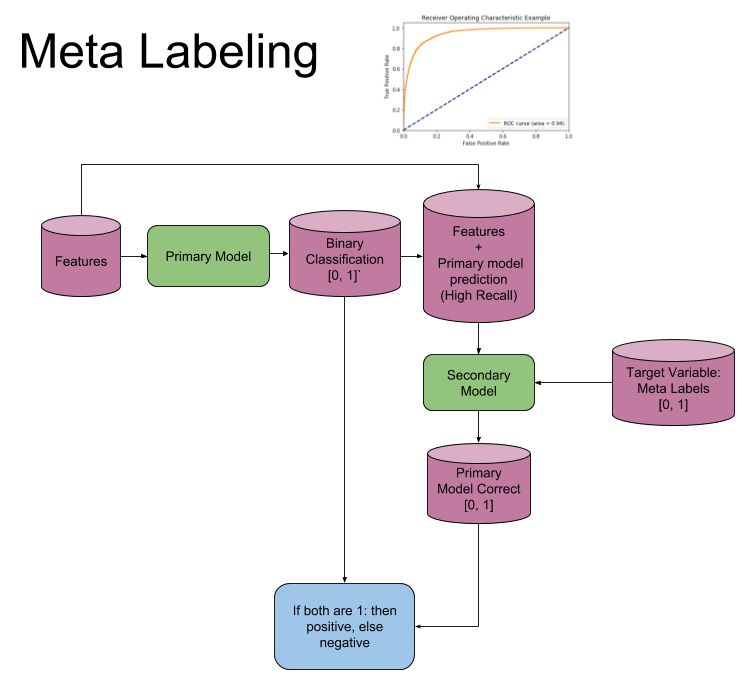

In [7]:
from IPython.core.display import Image
Image(filename='/content/drive/My Drive/Colab Notebooks/images/meta-labeling.png')

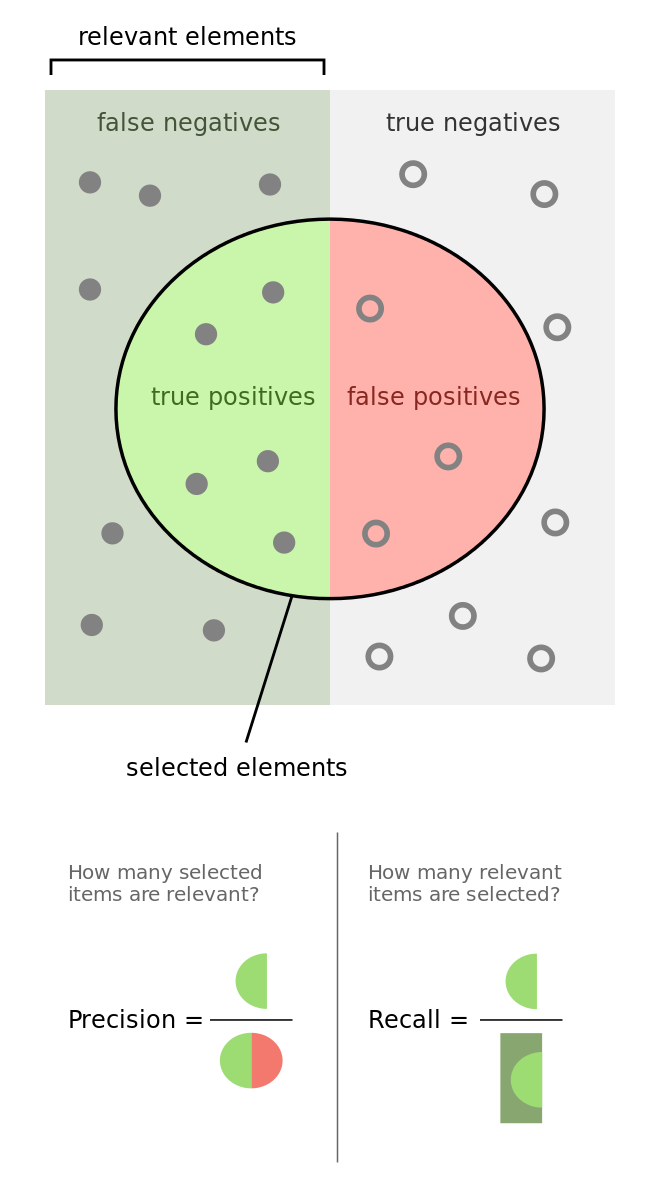

In [8]:
Image(filename='/content/drive/My Drive/Colab Notebooks/images/f1.png')

F-score (F1 score) is the harmonic mean of precision and recall

### Steps 


https://hudsonthames.org/does-meta-labeling-add-to-signal-efficacy-triple-barrier-method/

1. Compute long short signals for the strategy. For instance, in the mean-reverting strategy, generate a long signal when the close price is below the lower Bollinger band and create a sell signal if the close price is higher than the upper Bollinger band. We call this the “Primary model”.

2. Get time stamps of the events using CUSUM (or cumulative sum control chart) filter and point estimate of the volatility. See section 4.2.
Determine events when one of the three exit points (profit taking, stop-loss and vertical barrier) occur. Advances in Financial Machine Learning discusses this in Chapter 3. The result of this step is a trade decision – long or short, or 1 or -1.

3. Determine the bet size. The prior step tell us the direction of the trade. This step says if we should trade or not – a one or zero decision.
Tune the hyper-parameters (max_depth and n_estimators) of Random Forest using grid search and cross-validation. We keep the random state constant for reproducibility of the results.

4. Train a machine-learning algorithm (we use Random Forest for illustration) with new features like one to five day serial correlations, one to five-day returns, 50-day volatility, and 14-day RSI. We iterate over this step number of times until we see in-sample results that are acceptable. In other words, we only exit this step when we consider the model to be ready and there is no turning back.

5. Evaluate the performance of in sample and out-of-sample or this meta-model model.
Evaluate the performance of the “Primary model”
Compare the performance of the meta-model and the primary model

## Read in data - dollar bars

E-mini S&P Future tick data

In [0]:
# make dollar bars from tick data
threshold = 2_000_000
raw_dollar_bars = data_structures.get_dollar_bars('/content/drive/My Drive/Colab Notebooks/csv/clean_IVE_tickbidask2.csv', threshold=threshold)
dollar_bars = raw_dollar_bars.set_index(pd.to_datetime(raw_dollar_bars.date_time))
dollar_bars = dollar_bars.drop(columns='date_time')
dollar_bars = dollar_bars.reset_index().drop_duplicates(subset='date_time', keep='last').set_index('date_time')

In [0]:
dollar_bars.head()

In [0]:
len(dollar_bars)

In [0]:
close = dollar_bars.close

In [0]:
%matplotlib inline
close.iloc[-200:].plot()

Why do we use dollar bars?

See Chapter 2

## Tripple-Barrier

In [0]:
pt_sl = [1,1] # The factor that multiplies 'target' to set the width of the barriers

target = util.get_daily_vol(close,lookback=100) # Dynamic threshold, The unit width of the horizontal barriers

#upper barrier = price *(1+pt*target)
#lower barrier = price *(1-sl*target)

In [94]:
target.mean()

0.008089597744241587

Event-based sampling

 We can characterize an event as significant, and let the ML
algorithm learn whether there is an accurate prediction function under those circumstances.
Perhaps the answer is no, in which case we would redefine what constitutes
an event, or try again with alternative features.

The Cusum Filter

The CUSUM filter is a quality-control method, designed to detect a shift in
the mean value of a measured quantity away from a target value.

In [0]:
h = target.mean() # threshold level (events took place)
t_events = filters.cusum_filter(close, h) # using symmetric cusum filter, get t_event

In [0]:
vertical_barrier_times = labeling.add_vertical_barrier(t_events, close, num_days=30)
# 청산시간을 한 달로 하자. 즉 웬만하면 keep

In [97]:
# events
min_ret = 0.001 # The minimum target return required for running a triple barrier search.

events_0 = labeling.get_events(close, t_events, pt_sl, target, min_ret, num_threads=3, 
                             vertical_barrier_times = vertical_barrier_times)

2020-02-12 12:03:20.390084 100.0% apply_pt_sl_on_t1 done after 0.07 minutes. Remaining 0.0 minutes.


In [98]:
events_0

t1      trgt  pt  sl
2009-09-30 09:45:01 2009-09-30 10:06:12  0.006354   1   1
2009-09-30 12:48:14 2009-10-01 09:39:37  0.008649   1   1
2009-10-01 09:39:37 2009-10-01 11:25:33  0.008122   1   1
2009-10-01 11:25:33 2009-10-01 15:51:50  0.007117   1   1
2009-10-01 15:51:50 2009-10-02 09:49:51  0.009257   1   1
...                                 ...       ...  ..  ..
2019-06-18 09:42:42 2019-06-20 09:30:00  0.007420   1   1
2019-06-20 09:30:00 2019-06-20 12:20:48  0.006680   1   1
2019-06-20 15:50:44 2019-06-25 10:20:49  0.006223   1   1
2019-06-25 10:20:49 2019-06-28 09:30:00  0.005485   1   1
2019-06-28 09:30:00                 NaT  0.005236   1   1

[2417 rows x 4 columns]

t1은 배리어도달시점, trgt은 호리존탈배리어 수익률의 절댓값

한 시점의 betting을 보자.

In [0]:
n=-6

In [100]:
events_0.index[n]

Timestamp('2019-06-17 15:41:28')

In [101]:
events_0.t1[n] #when barrier touched

Timestamp('2019-06-18 09:42:42')

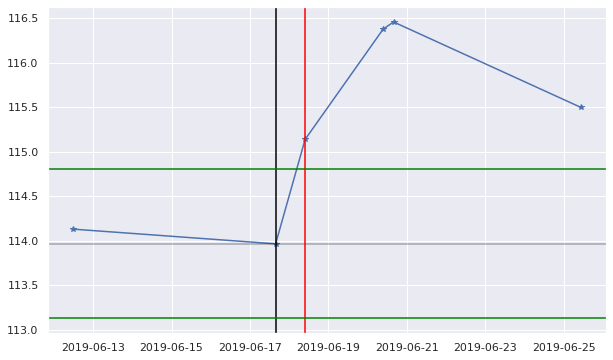

In [102]:
dstart = events_0.index[n]
dclose = close.loc[events_0.index]
dprice = close.loc[dstart]
dt1 = events_0.t1[n]
dpt = events_0.pt[n]
dsl = events_0.sl[n]
dtrgt = events_0.trgt[n]
dhbarrier = dprice+ dprice*(dpt*dtrgt)
dlbarrier = dprice- dprice*(dpt*dtrgt)

plt.figure(figsize=(10,6))
plt.plot(dclose.iloc[n-1:n+5], marker='*')
plt.axvline(dstart, color='black') # start date
plt.axhline(dprice, color='black',alpha=0.3) # start price
plt.axvline(dt1, color='red') # touched
plt.axhline(dhbarrier, color='green')
plt.axhline(dlbarrier, color='green')

세로선

검정 선: 시작 시점 (event-based sampling에 의한 T-events)

빨간 선: 배리어에 도달한 시점

- vertical barrier는 시작시점에서 7일뒤로, 그래프에 표시하지 않았다.

--------------
가로선

회색선: 시작시점 가격

녹색선: Horizontal barrier (profit-taking, stop-loss 가격)

In [0]:
# label (bin) - -1(short), 1(long) - return에 따라 결정 됨.
bin_0 = labeling.get_bins(events_0, close)

In [0]:
dret = bin_0.ret[n+1]
dbin = bin_0.bin[n+1]

In [105]:
print(bin_0.trgt[n+1] == events_0.trgt[n])

True


In [106]:
dret, ((close.loc[dt1]/dprice)-1)

(0.010297021015224672, 0.010297021015223784)

ret은 배리어에 닿은 시점과 시작 시점의 수익률이다.

In [107]:
dtrgt, ((close.loc[dt1]/dprice)-1)

(0.007367338550509591, 0.010297021015223784)

target을 넘은 다음 시점에서 거래한다.

In [108]:
dbin == np.sign(dret)
# if false, horizontal doesn't get touched

True

ret의 sign(+이면 pt, -이면 sl)에 따라 bin이 정해진다. 단 bin=0인 것은 vertical barrier에 닿았을때이다.

In [109]:
bin_0.iloc[n+1]

ret     0.010297
trgt    0.007367
bin     1.000000
Name: 2019-06-17 15:41:28, dtype: float64

In [110]:
bin_0.bin.value_counts()

 1    1283
-1    1091
 0      42
Name: bin, dtype: int64

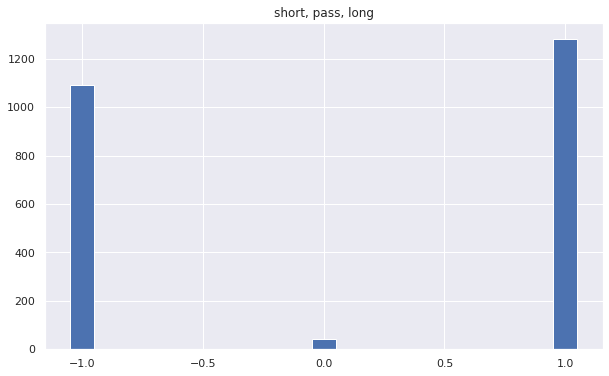

In [111]:
plt.figure(figsize=(10,6))
plt.title('short, pass, long')
plt.bar(bin_0.bin.value_counts().index,height=bin_0.bin.value_counts(),width=0.1)
plt.show();

#### Actual Side

In [112]:
side_0 = bin_0.bin
side_0 = side_0[side_0 != 0 ] # vertical touch 제외
side_0

2009-09-30 09:45:01   -1
2009-09-30 12:48:14   -1
2009-10-01 09:39:37   -1
2009-10-01 11:25:33   -1
2009-10-01 15:51:50   -1
                      ..
2019-06-17 15:41:28    1
2019-06-18 09:42:42    1
2019-06-20 09:30:00   -1
2019-06-20 15:50:44   -1
2019-06-25 10:20:49    1
Name: bin, Length: 2374, dtype: int64

In [113]:
side_0.value_counts()

 1    1283
-1    1091
Name: bin, dtype: int64

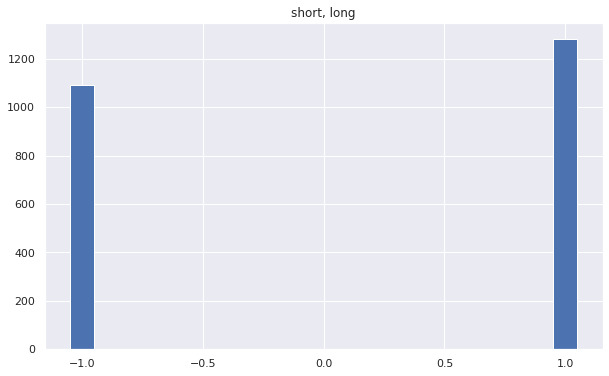

In [114]:
plt.figure(figsize=(10,6))
plt.title('short, long')
plt.bar(side_0.value_counts().index,height=side_0.value_counts(),width=0.1)
plt.show();

## Primary Model

### First Option
- Based on the simple moving average cross-over strategy.

In [0]:
fast_window = 20
slow_window = 50

df = pd.DataFrame()
df['fast_mavg'] = close.rolling(window=fast_window, min_periods=fast_window, center=False).mean()
df['slow_mavg'] = close.rolling(window=slow_window, min_periods=slow_window, center=False).mean()
df['side1'] = np.nan

long_signals = df['fast_mavg'] >= df['slow_mavg'] 
short_signals = df['fast_mavg'] < df['slow_mavg'] 
df.loc[long_signals, 'side1'] = 1
df.loc[short_signals, 'side1'] = -1

df['side1'] = df['side1'].shift(1)

sma_crossover = df['side1']

In [37]:
df

fast_mavg   slow_mavg  side1
date_time                                         
2009-09-28 09:53:49         NaN         NaN    NaN
2009-09-28 10:02:52         NaN         NaN    NaN
2009-09-28 10:17:30         NaN         NaN    NaN
2009-09-28 10:32:06         NaN         NaN    NaN
2009-09-28 11:07:36         NaN         NaN    NaN
...                         ...         ...    ...
2019-06-28 15:55:01  116.024010  115.857388    1.0
2019-06-28 15:58:59  116.085510  115.859588    1.0
2019-06-28 15:59:07  116.148510  115.860388    1.0
2019-06-28 16:00:00  116.216510  115.866588    1.0
2019-06-28 17:29:22  116.259625  115.872470    1.0

[31186 rows x 3 columns]

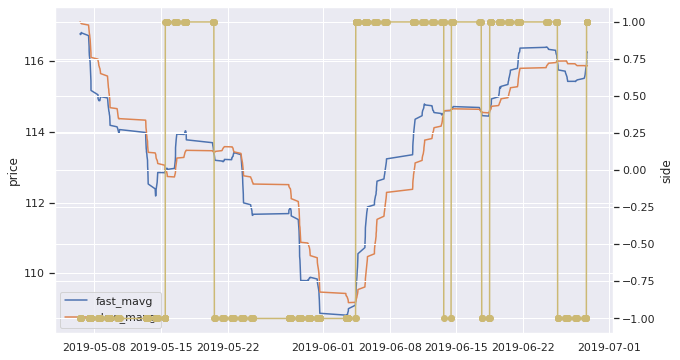

In [38]:
f,ax=plt.subplots(figsize=(10,6))
# make a plot
ax.plot(df.iloc[-500:,:2])
ax.set_ylabel("price")
ax.legend(labels = df[:2].columns)
ax2=ax.twinx()
ax2.plot(df.side1.iloc[-500:],color="y",marker="o")
ax2.set_ylabel("side")
plt.show()

In [0]:
# side = sma_crossover
# side.value_counts()

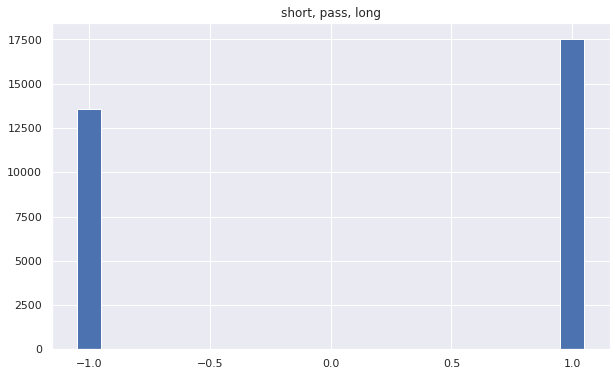

In [40]:
plt.figure(figsize=(10,6))
plt.title('short, pass, long')
plt.bar(sma_crossover.value_counts().index,height=sma_crossover.value_counts(),width=0.1)
plt.show();

### Second Option
- Based on the mean-reverting Bollinger band strategy.

In [0]:
n=20

df = pd.DataFrame()

df['lower'] = ta.volatility.bollinger_lband(close,n)
df['upper'] = ta.volatility.bollinger_hband(close,n)
df['close'] = close
df['side'] = np.nan

long_signals = (df['close'] <= df['lower']) 
short_signals = (df['close'] >= df['upper']) 

df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
df['side'] = df['side'].shift(1)

bbsignal = df['side']

In [42]:
df

lower       upper     close  side
date_time                                                  
2009-09-28 09:53:49   51.140000   51.140000   51.1400   NaN
2009-09-28 10:02:52   51.085000   51.305000   51.2500  -1.0
2009-09-28 10:17:30   51.105913   51.333487   51.2691   NaN
2009-09-28 10:32:06   51.098335   51.411215   51.3600   NaN
2009-09-28 11:07:36   51.116168   51.427472   51.3400   NaN
...                         ...         ...       ...   ...
2019-06-28 15:55:01  115.151830  116.896190  116.4564   NaN
2019-06-28 15:58:59  115.241936  116.929084  116.5700   NaN
2019-06-28 15:59:07  115.362785  116.934235  116.5600   NaN
2019-06-28 16:00:00  115.539577  116.893443  116.5700   NaN
2019-06-28 17:29:22  115.608460  116.910790  116.5700   NaN

[31186 rows x 4 columns]

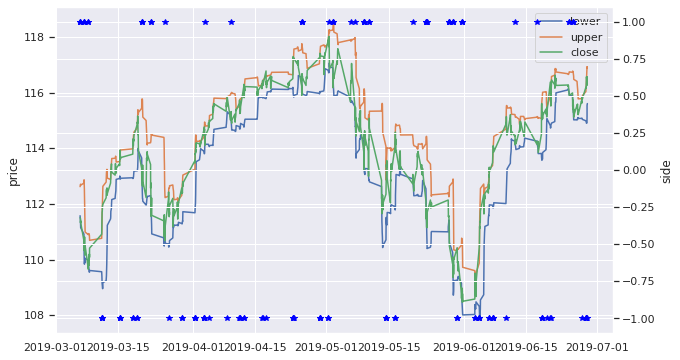

In [43]:
f,ax=plt.subplots(figsize=(10,6))
# make a plot
ax.plot(df.iloc[-1000:,:3])
ax.set_ylabel("price")
ax.legend(labels = df[:3].columns)
ax2=ax.twinx()
ax2.plot(df.side.iloc[-1000:],color="blue",marker="*")
ax2.set_ylabel("side")
plt.show()


In [0]:
#side = bbsignal
#side.value_counts()

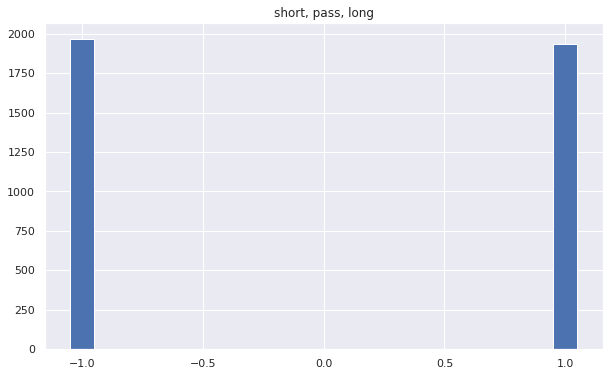

In [45]:
plt.figure(figsize=(10,6))
plt.title('short, pass, long')
plt.bar(bbsignal.value_counts().index,height=bbsignal.value_counts(),width=0.1)
plt.show();

### Third Option
- Based on Logistic Regression
- Use fist, (X)second option as features
- (X) Use history price features

### Fourth - VPIN

In [0]:
vpin = microstructural_features.third_generation.get_vpin(dollar_bars.volume,buy_volume=dollar_bars.cum_buy_volume)

In [0]:
y_side = side_0

vpin = vpin.shift(1)
X_side=pd.DataFrame()
X_side['vpin'] = vpin.loc[y_side.index]

In [0]:
#X_side['side'] = np.nan
#X_side.loc[X_side['vpin']>0.05, 'side'] =1
#X_side.loc[X_side['vpin']<=0.05, 'side'] =-1

In [0]:
#side = X_side['side']
#side.value_counts()

In [0]:
tc = DecisionTreeClassifier(criterion='gini',max_depth=12)
tc = tc.fit(X_side,y_side)

In [0]:
y_pred_side = tc.predict(X_side)

              precision    recall  f1-score   support

          -1       0.78      0.26      0.40      1091
           1       0.60      0.94      0.73      1283

    accuracy                           0.63      2374
   macro avg       0.69      0.60      0.56      2374
weighted avg       0.68      0.63      0.58      2374

Accuracy =  0.6272114574557709

Confusion Matrix


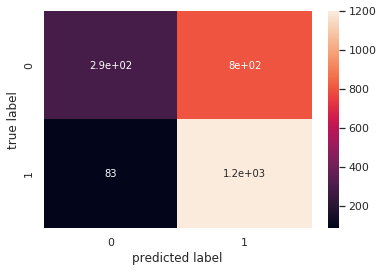

In [175]:
print(classification_report(y_side,y_pred_side))

print("Accuracy = ", accuracy_score(y_side,y_pred_side))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_side,y_pred_side)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

In [0]:
side = pd.Series(y_pred_side, index = X_side.index)

## 2. Generate labels (from a primary model)

Get time stamps of the events using CUSUM filter and point estimate of the volatility.

In [181]:
pt_sl = [1,2]

# events
min_ret = 0.001

events = labeling.get_events(close, t_events, pt_sl, target, min_ret, num_threads=3, 
                             vertical_barrier_times = vertical_barrier_times ,side_prediction = side)


2020-02-12 12:16:17.268108 100.0% apply_pt_sl_on_t1 done after 0.07 minutes. Remaining 0.0 minutes.


In [182]:
events

t1      trgt  side  pt  sl
2009-09-30 09:45:01 2009-10-01 10:17:19  0.006354   1.0   1   2
2009-09-30 12:48:14 2009-10-01 11:25:33  0.008649   1.0   1   2
2009-10-01 09:39:37 2009-10-01 15:51:50  0.008122   1.0   1   2
2009-10-01 11:25:33 2009-10-02 09:49:51  0.007117   1.0   1   2
2009-10-01 15:51:50 2009-10-02 09:49:51  0.009257  -1.0   1   2
...                                 ...       ...   ...  ..  ..
2019-06-18 09:42:42 2019-06-20 09:30:00  0.007420   1.0   1   2
2019-06-20 09:30:00 2019-06-20 12:20:48  0.006680  -1.0   1   2
2019-06-20 15:50:44                 NaT  0.006223   1.0   1   2
2019-06-25 10:20:49 2019-06-28 09:30:00  0.005485   1.0   1   2
2019-06-28 09:30:00                 NaT  0.005236   NaN   1   2

[2417 rows x 5 columns]

In [0]:
n=-6

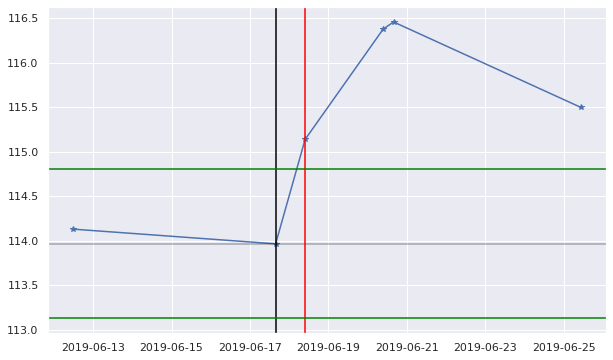

In [184]:
mstart = events.index[n]
mclose = close.loc[events.index]
mprice = close.loc[mstart]
mt1 = events.t1[n]
mpt = events.pt[n]
msl = events.sl[n]
mtrgt = events.trgt[n]
mhbarrier = mprice+ mprice*(mpt*mtrgt)
mlbarrier = mprice- mprice*(mpt*mtrgt)

plt.figure(figsize=(10,6))
plt.plot(mclose.iloc[n-1:n+5], marker='*')
plt.axvline(mstart, color='black') # start date
plt.axhline(mprice, color='black',alpha=0.3) # start price
plt.axvline(mt1, color='red') # touched
plt.axhline(mhbarrier, color='green')
plt.axhline(mlbarrier, color='green')

In [185]:
events.iloc[n]

t1      2019-06-18 09:42:42
trgt             0.00736734
side                      1
pt                        1
sl                        2
Name: 2019-06-17 15:41:28, dtype: object

In [0]:
# label (bin) - meta-labeling: 0(pass), 1(go)

bin = labeling.get_bins(events, close)

In [187]:
bin

ret      trgt  bin  side
2009-09-30 09:45:01 -0.014135  0.006354    0   1.0
2009-09-30 12:48:14 -0.017551  0.008649    0   1.0
2009-10-01 09:39:37 -0.017136  0.008122    0   1.0
2009-10-01 11:25:33 -0.018658  0.007117    0   1.0
2009-10-01 15:51:50  0.010498  0.009257    1  -1.0
...                       ...       ...  ...   ...
2019-06-12 11:59:18  0.008838  0.008536    1   1.0
2019-06-17 15:41:28  0.010297  0.007367    1   1.0
2019-06-18 09:42:42  0.010783  0.007420    1   1.0
2019-06-20 09:30:00  0.007445  0.006680    1  -1.0
2019-06-25 10:20:49  0.005974  0.005485    1   1.0

[2414 rows x 4 columns]

In [0]:
mret = bin.ret[n+1]
mside = bin.side[n+1]
mbin = bin.bin[n+1]

In [189]:
print('Long 했을 때의 수익률 =',(close.loc[mt1]/mprice)-1)

Long 했을 때의 수익률 = 0.010297021015223784


In [190]:
print('Primary model의 buy/sell 결정에 따른 수익률 =', mret, mside*((close.loc[mt1]/mprice)-1))

Primary model의 buy/sell 결정에 따른 수익률 = 0.008838182490462865 0.010297021015223784


In [191]:
.5+.5*np.sign(mret) == mbin

True

ret이 +이면 bin=1 (gain), ret이 -이면 bin=0 (loss)

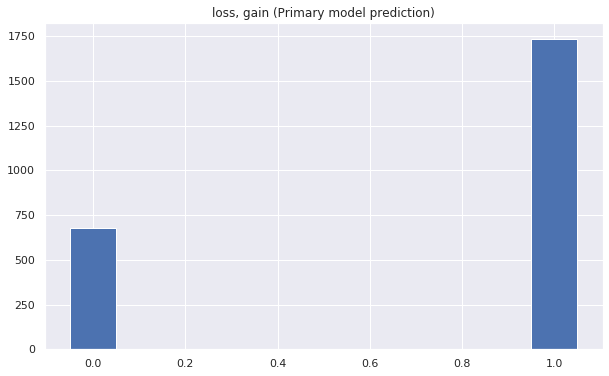

In [192]:
plt.figure(figsize=(10,6))
plt.title('loss, gain (Primary model prediction)')
plt.bar(bin.bin.value_counts().index,height=bin.bin.value_counts(),width=0.1)
plt.show();

## 3. Features


### Bet Sizing

In [193]:
bars = dollar_bars.iloc[:,1:6]
bars = bars.loc[bin.index,:]
bars.head()

open   high      low   close  volume
2009-09-30 09:45:01  51.500  51.69  51.2500  51.250   38947
2009-09-30 12:48:14  51.012  51.28  50.9100  51.280   39744
2009-10-01 09:39:37  51.170  51.29  50.7500  50.830   39218
2009-10-01 11:25:33  50.610  50.62  50.2900  50.380   57184
2009-10-01 15:51:50  50.080  50.14  49.9405  49.959   40062

In [0]:
bs_df = bin.join(events.t1.loc[bin.index])

In [0]:
from mlfinlab import bet_sizing as bs

In [204]:
m_reserve = bs.bet_sizing.bet_size_reserve(events_t1=bs_df['t1'], sides=bs_df.side, return_parameters=True, fit_runs=30)
m_reserve[0]

|#########################| Completed 30 of 30 fitting rounds.

t1  side  ...  c_t  bet_size
2009-09-30 09:45:01 2009-10-01 10:17:19   1.0  ...    1  0.164745
2009-09-30 12:48:14 2009-10-01 11:25:33   1.0  ...    2  0.411747
2009-10-01 09:39:37 2009-10-01 15:51:50   1.0  ...    3  0.656932
2009-10-01 11:25:33 2009-10-02 09:49:51   1.0  ...    2  0.411747
2009-10-01 15:51:50 2009-10-02 09:49:51  -1.0  ...    0  0.000000
...                                 ...   ...  ...  ...       ...
2019-06-12 11:59:18 2019-06-18 09:42:42   1.0  ...    1  0.164745
2019-06-17 15:41:28 2019-06-18 09:42:42   1.0  ...    2  0.411747
2019-06-18 09:42:42 2019-06-20 09:30:00   1.0  ...    1  0.164745
2019-06-20 09:30:00 2019-06-20 12:20:48  -1.0  ...   -1 -0.733291
2019-06-25 10:20:49 2019-06-28 09:30:00   1.0  ...    1  0.164745

[2414 rows x 6 columns]

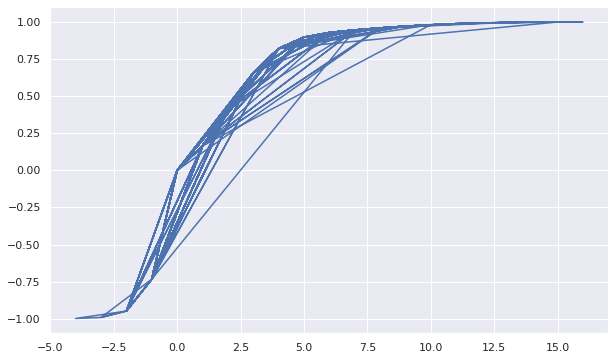

In [208]:
plt.figure(figsize=(10,6))
plt.plot(m_reserve[0].c_t, m_reserve[0].bet_size)

In [205]:
m_budget = bs.bet_sizing.bet_size_budget(bs_df.t1, bs_df.side)
m_budget

t1  side  ...  active_short  bet_size
2009-09-30 09:45:01 2009-10-01 10:17:19   1.0  ...             0  0.058824
2009-09-30 12:48:14 2009-10-01 11:25:33   1.0  ...             0  0.117647
2009-10-01 09:39:37 2009-10-01 15:51:50   1.0  ...             0  0.176471
2009-10-01 11:25:33 2009-10-02 09:49:51   1.0  ...             0  0.117647
2009-10-01 15:51:50 2009-10-02 09:49:51  -1.0  ...             1 -0.141176
...                                 ...   ...  ...           ...       ...
2019-06-12 11:59:18 2019-06-18 09:42:42   1.0  ...             0  0.058824
2019-06-17 15:41:28 2019-06-18 09:42:42   1.0  ...             0  0.117647
2019-06-18 09:42:42 2019-06-20 09:30:00   1.0  ...             0  0.058824
2019-06-20 09:30:00 2019-06-20 12:20:48  -1.0  ...             1 -0.200000
2019-06-25 10:20:49 2019-06-28 09:30:00   1.0  ...             0  0.058824

[2414 rows x 5 columns]

In [0]:
X = pd.DataFrame({'c_t':m_reserve[0].c_t})

X = pd.DataFrame({'m_r':m_reserve[0].bet_size,'m_b':m_budget.bet_size})

### Including side from first model

In [0]:
X['vpin'] = X_side.vpin

In [0]:
X['side'] = side

### X

In [0]:
#X['fd'] = fd

In [353]:
X.head(3)

m_r       m_b      vpin  side
2009-09-30 09:45:01  0.164745  0.058824  0.132180   1.0
2009-09-30 12:48:14  0.411747  0.117647  0.152282   1.0
2009-10-01 09:39:37  0.656932  0.176471  0.157275   1.0

In [0]:
X.dropna(inplace=True)

In [355]:
len(X)

2372

## 4. Fit a second ML model

In [0]:
tmp_data = X.copy()
tmp_data = tmp_data.join(bin.bin)
tmp_data.dropna(inplace=True)

X = tmp_data.iloc[:,:-1]
y = tmp_data[['bin']]

In [0]:
t1 = events['t1'].loc[X.index]
idx = events.loc[X.index].index

In [0]:
#skf = cross_validation.PurgedKFold(n_splits=5,samples_info_sets= t1, pct_embargo = 0.01)

In [0]:
X_train,X_test,y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

### 1st - Random Forest

In [361]:
avgU = sampling.get_av_uniqueness_from_triple_barrier(t1.to_frame(), bars.close, 3).mean()
max_samples = avgU[0]
max_samples

2020-02-12 13:03:27.141975 100.0% num_concurrent_events done after 0.03 minutes. Remaining 0.0 minutes.
2020-02-12 13:03:28.288545 100.0% _get_average_uniqueness done after 0.02 minutes. Remaining 0.0 minutes.


0.34037483828016035

In [362]:
parameters = { 'n_estimators' : [512, 1000, 2000],
               'max_depth' : [2, 5, 9, 12]}
#hyper-parameter tuning

rf = RandomForestClassifier(criterion='entropy',max_samples=max_samples, class_weight='balanced_subsample')
clf = GridSearchCV(rf, parameters, cv=3, n_jobs=-1)
clf.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced_subsample',
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=0.34037483828016035,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                  

In [0]:
clf = clf.best_estimator_

In [0]:
#clf0 = RandomForestClassifier(n_estimators=1,max_depth=18,criterion='entropy',bootstrap = False, class_weight='balanced_subsample')
#clf1 = BaggingClassifier(base_estimator=clf0, max_samples=max_samples, n_estimators=200)
#clf = clf1.fit(X_train, y_train.values.ravel())
#this is the method in the book

#### Primary model prediction

In [0]:
#actual = bin_1.bin.loc[X_test.index]
#pred = bin.bin.loc[X_test.index]

In [366]:
'''print(classification_report(actual,pred))

print("Accuracy = ", accuracy_score(actual,pred))
print('')
print("Confusion Matrix")
mat = confusion_matrix(actual, pred)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');'''

'print(classification_report(actual,pred))\n\nprint("Accuracy = ", accuracy_score(actual,pred))\nprint(\'\')\nprint("Confusion Matrix")\nmat = confusion_matrix(actual, pred)\nsns.heatmap(mat , annot=True)\nplt.xlabel(\'predicted label\')\nplt.ylabel(\'true label\');'

#### Train metrics - RF

In [0]:
y_pred_prob_0 = clf.predict_proba(X_train)[:, 1]
y_pred_0 = clf.predict(X_train)

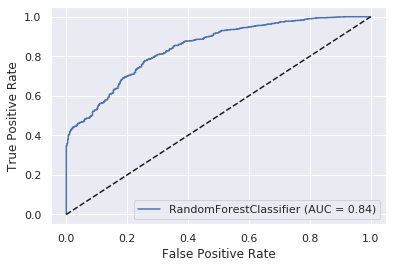

In [368]:
rf_disp = plot_roc_curve(clf, X_train, y_train)
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       453
           1       0.86      0.87      0.86      1207

    accuracy                           0.80      1660
   macro avg       0.75      0.74      0.74      1660
weighted avg       0.80      0.80      0.80      1660

Accuracy =  0.7993975903614458

Confusion Matrix


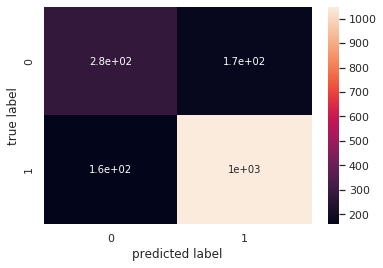

In [369]:
print(classification_report(y_train, y_pred_0))

print("Accuracy = ", accuracy_score(y_train, y_pred_0))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_train, y_pred_0)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

#### Test metrics -RF

In [0]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

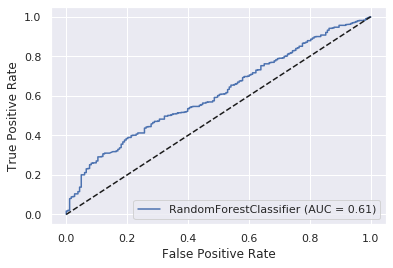

In [371]:
rf_disp = plot_roc_curve(clf, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.show();

              precision    recall  f1-score   support

           0       0.32      0.32      0.32       183
           1       0.77      0.77      0.77       529

    accuracy                           0.65       712
   macro avg       0.54      0.54      0.54       712
weighted avg       0.65      0.65      0.65       712

Accuracy =  0.6530898876404494

Confusion Matrix


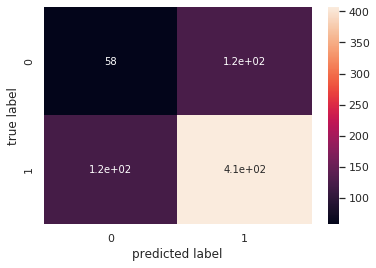

In [372]:
print(classification_report(y_test, y_pred))

print("Accuracy = ", accuracy_score(y_test, y_pred))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

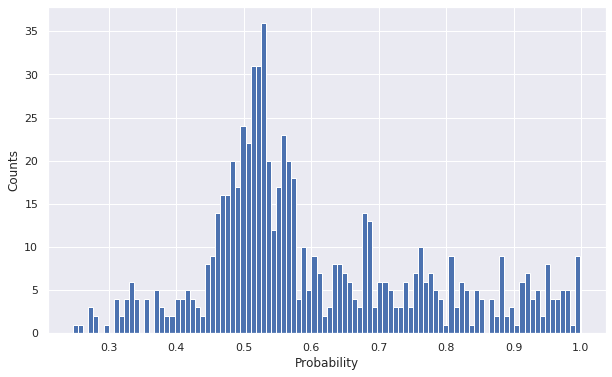

In [373]:
p = pd.Series(y_pred_prob)
f=plt.figure(figsize=(10,6))
a = f.gca()
a.hist(p,bins=100)
plt.xlabel('Probability')
plt.ylabel('Counts')
plt.show()

## 5. Bet Sizing

When num_classes = 2,



$$ z=\frac{p[x=1]−\frac{1}{2}}{\sqrt{p[x=1](1−p[x=1])}} $$

$$ m=x(2Z[z]−1) $$

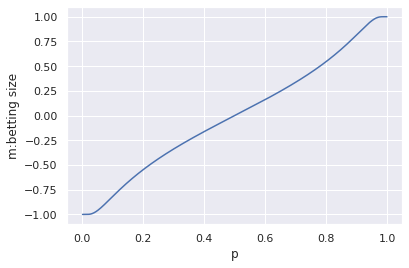

In [374]:
import scipy.stats as ss
p = np.linspace(0.001,1,1000,endpoint=False)
z = (p-0.5)/(np.sqrt(p*(1-p)))
Z_z = ss.norm.cdf(z)
m = (2 * Z_z -1) # np.sign(x)=1 always? increasing function
plt.plot(p,m)
plt.xlabel('p');
plt.ylabel('m:betting size');

In [0]:
p_rf = y_pred_prob # from RF (secondary model)
#p = y_pred_prob_svc # from SVM
#p_gbc = y_pred_prob_gbc # from Gradient Boosting

In [378]:
new_data = y_test.copy()
new_data['bin_pred_rf'] = y_pred
new_data['p'] = p_rf
new_data

bin  bin_pred_rf         p
2016-04-19 10:36:01    1            1  0.502806
2016-04-20 14:17:54    1            1  0.823203
2016-04-25 10:54:37    1            1  0.612159
2016-04-26 10:09:27    1            0  0.426485
2016-04-27 14:09:17    1            1  0.935367
...                  ...          ...       ...
2019-06-12 11:59:18    1            1  0.545008
2019-06-17 15:41:28    1            0  0.482219
2019-06-18 09:42:42    1            0  0.471367
2019-06-20 09:30:00    1            1  0.805685
2019-06-25 10:20:49    1            0  0.495613

[712 rows x 3 columns]

In [0]:
new_events = events.loc[new_data.index]
bs_df = pd.concat([new_events, new_data],axis=1)

In [380]:
bs_df.head()

t1      trgt  ...  bin_pred_rf         p
2016-04-19 10:36:01 2016-04-27 10:00:17  0.006619  ...            1  0.502806
2016-04-20 14:17:54 2016-04-21 12:25:51  0.006014  ...            1  0.823203
2016-04-25 10:54:37 2016-04-26 09:43:22  0.005980  ...            1  0.612159
2016-04-26 10:09:27 2016-04-27 14:56:19  0.005945  ...            0  0.426485
2016-04-27 14:09:17 2016-04-28 09:30:00  0.005434  ...            1  0.935367

[5 rows x 8 columns]

In [382]:
m_prob_rf = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p, num_classes=2, num_threads=3, pred=bs_df.side)
m_prob_rf

2016-04-19 10:36:01    0.004477
2016-04-20 14:17:54   -0.603114
2016-04-25 10:54:37    0.182052
2016-04-26 10:09:27   -0.118166
2016-04-27 14:09:17   -0.923385
                         ...   
2019-06-12 11:59:18    0.072018
2019-06-17 15:41:28   -0.028386
2019-06-18 09:42:42   -0.045742
2019-06-20 09:30:00   -0.560224
2019-06-25 10:20:49   -0.007001
Name: signal, Length: 712, dtype: float64

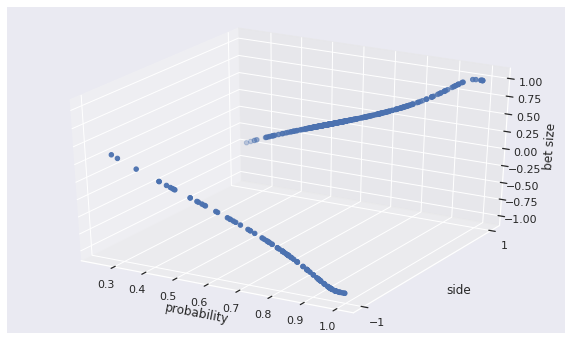

In [384]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,6))							
ax = fig.gca(projection='3d')
ax.scatter(bs_df.p,bs_df.side, m_prob_rf)									
ax.set_zlabel('bet size')
plt.ylabel('side')
plt.yticks([-1,1])
plt.xlabel('probability')

plt.show()

### Average

Every bet is associated with a holding period, spanning from the time it originated to
the time the first barrier is touched, t1. One possible approach is to
override an old bet as a new bet arrives; however, that is likely to lead to excessive
turnover. A more sensible approach is to average all sizes across all bets still active at a
given point in time.

In [386]:
m_prob_avg_rf = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p, num_classes=2, num_threads=3, average_active=True, pred=bs_df.side)
m_prob_avg_rf = m_prob_avg_rf.loc[bs_df.index]
m_prob_avg_rf

2020-02-12 13:08:39.906186 100.0% mp_avg_active_signals done after 0.04 minutes. Remaining 0.0 minutes.


2016-04-19 10:36:01    0.004477
2016-04-20 14:17:54   -0.299318
2016-04-25 10:54:37    0.093264
2016-04-26 10:09:27   -0.056845
2016-04-27 14:09:17   -0.520775
                         ...   
2019-06-12 11:59:18    0.072018
2019-06-17 15:41:28    0.021816
2019-06-18 09:42:42   -0.045742
2019-06-20 09:30:00   -0.560224
2019-06-25 10:20:49   -0.007001
Length: 712, dtype: float64

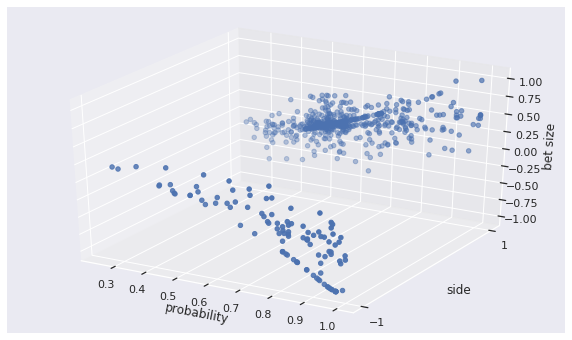

In [387]:
fig = plt.figure(figsize=(10,6))							
ax = fig.gca(projection='3d')
ax.scatter(bs_df.p,bs_df.side, m_prob_avg_rf)
ax.set_zlabel('bet size')
plt.ylabel('side')
plt.yticks([-1,1])
plt.xlabel('probability')							
plt.show()

### Discrete

Averaging reduces some of the excess turnover, but still it is likely that small trades
will be triggered with every prediction. As this jitter would cause unnecessary overtrading, I suggest you discretize the bet size as $m^∗=\text{round}[\frac{m}{d}]d$, where $d ∈
(0, 1]$ determines the degree of discretization.

In [388]:
m_prob_discrete_rf = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p, num_classes=2,pred=bs_df.side, num_threads=3, average_active=True, step_size=0.05)
m_prob_discrete_rf = m_prob_discrete_rf.loc[bs_df.index]
m_prob_discrete_rf

2020-02-12 13:09:01.199309 100.0% mp_avg_active_signals done after 0.04 minutes. Remaining 0.0 minutes.


2016-04-19 10:36:01    0.00
2016-04-20 14:17:54   -0.30
2016-04-25 10:54:37    0.10
2016-04-26 10:09:27   -0.05
2016-04-27 14:09:17   -0.50
                       ... 
2019-06-12 11:59:18    0.05
2019-06-17 15:41:28    0.00
2019-06-18 09:42:42   -0.05
2019-06-20 09:30:00   -0.55
2019-06-25 10:20:49   -0.00
Length: 712, dtype: float64

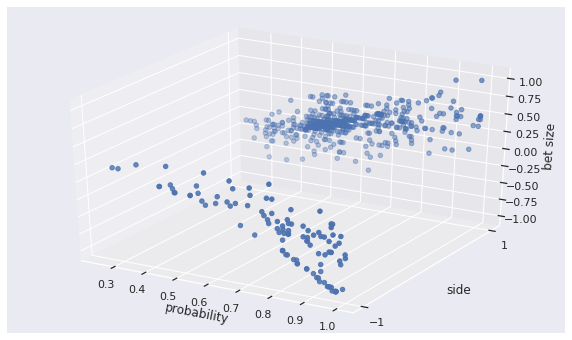

In [389]:
fig = plt.figure(figsize=(10,6))							
ax = fig.gca(projection='3d')
ax.scatter(bs_df.p,bs_df.side, m_prob_discrete_rf)
ax.set_zlabel('bet size')
plt.ylabel('side')
plt.yticks([-1,1])
plt.xlabel('probability')
plt.show()

### plot

In [0]:
bet_sizes_rf = pd.DataFrame({'m_rf':m_prob_rf,'m_avg_rf':m_prob_avg_rf,'m_dis_rf':m_prob_discrete_rf})
#bet_sizes_gbc = pd.DataFrame({'m_gb':m_prob_gbc,'m_avg_gb':m_prob_avg_gbc,'m_dis_gb':m_prob_discrete_gbc})

Text(0.5, 1.0, 'Bet Size 100 points')

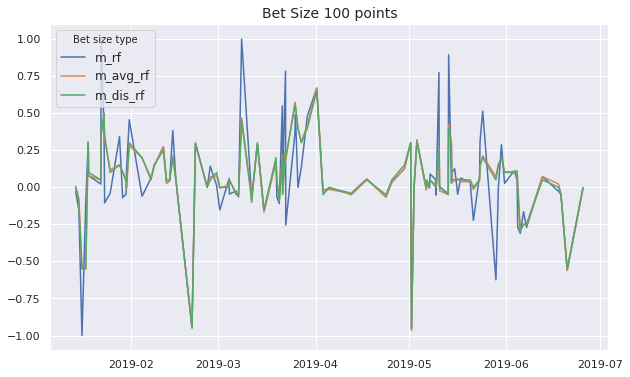

In [391]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(bet_sizes_rf[-100:])
ax.legend(labels=bet_sizes_rf.columns,loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_title("Bet Size 100 points", fontsize=14)

Text(0.5, 1.0, 'Bet Size Distribution RF')

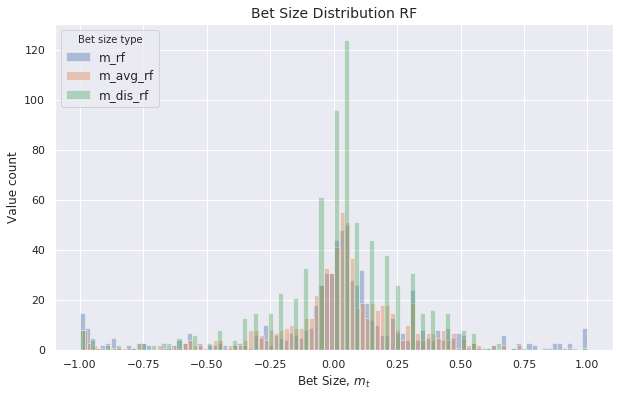

In [392]:
fig, ax = plt.subplots(figsize=(10,6))
for c in ['m_rf','m_avg_rf','m_dis_rf']:
    ax.hist(bet_sizes_rf[c],  label=c, alpha=0.4, bins=100)
ax.legend(loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_xlabel("Bet Size, $m_t$", fontsize=12)
ax.set_ylabel("Value count", fontsize=12)
ax.set_title("Bet Size Distribution RF", fontsize=14)

# Other methods

### Reserve

$c_t = c_{t,l} - c_{t,s} $ 

where $c_{t,l}$ is the number of concurrent long bets at
time $t$, and $c_{t,s}$ is the number of concurrent short bets at time $t$

$$m_t = \begin{cases}
  \frac{F[c_t]-F[0]}{1-F[0]} & \text{if}\ c_t \ge 0 \\
  \frac{F[c_t]-F[0]}{F[0]} & \text{if}\ c_t < 0
\end{cases}$$

where $F[x]$ is CDF of the fitted mixture of two Gaussians for a value x.

EF3M Algorithm

https://github.com/hudson-and-thames/research/blob/master/Chapter10/ef3m_testing.ipynb

In [393]:
m_reserve = bs.bet_sizing.bet_size_reserve(events_t1=bs_df['t1'], sides=bs_df.side, return_parameters=True, fit_runs=25)
m_reserve[0]

|#########################| Completed 25 of 25 fitting rounds.

t1  side  ...  c_t  bet_size
2016-04-19 10:36:01 2016-04-27 10:00:17   1.0  ...    1  0.197739
2016-04-20 14:17:54 2016-04-21 12:25:51  -1.0  ...    0  0.000000
2016-04-25 10:54:37 2016-04-26 09:43:22   1.0  ...    2  0.482279
2016-04-26 10:09:27 2016-04-27 14:56:19   1.0  ...    2  0.482279
2016-04-27 14:09:17 2016-04-28 09:30:00  -1.0  ...    0  0.000000
...                                 ...   ...  ...  ...       ...
2019-06-12 11:59:18 2019-06-18 09:42:42   1.0  ...    1  0.197739
2019-06-17 15:41:28 2019-06-18 09:42:42   1.0  ...    2  0.482279
2019-06-18 09:42:42 2019-06-20 09:30:00   1.0  ...    1  0.197739
2019-06-20 09:30:00 2019-06-20 12:20:48  -1.0  ...   -1 -0.763274
2019-06-25 10:20:49 2019-06-28 09:30:00   1.0  ...    1  0.197739

[712 rows x 6 columns]

In [394]:
print('Parameters are ',m_reserve[1])

Parameters are  {'mu_1': 1.75058, 'mu_2': 6.50428, 'sigma_1': 1.40622, 'sigma_2': 1.23043, 'p_1': 0.93607}


### Budget

$$ m_t = c_{t,l} \frac{1}{max_i[c_{i,l}]}-c_{t,s} \frac{1}{max_i[c_{i,s}]} $$

In [395]:
m_budget = bs.bet_sizing.bet_size_budget(bs_df.t1, bs_df.side)
m_budget

t1  side  ...  active_short  bet_size
2016-04-19 10:36:01 2016-04-27 10:00:17   1.0  ...             0  0.111111
2016-04-20 14:17:54 2016-04-21 12:25:51  -1.0  ...             1 -0.388889
2016-04-25 10:54:37 2016-04-26 09:43:22   1.0  ...             0  0.222222
2016-04-26 10:09:27 2016-04-27 14:56:19   1.0  ...             0  0.222222
2016-04-27 14:09:17 2016-04-28 09:30:00  -1.0  ...             1 -0.388889
...                                 ...   ...  ...           ...       ...
2019-06-12 11:59:18 2019-06-18 09:42:42   1.0  ...             0  0.111111
2019-06-17 15:41:28 2019-06-18 09:42:42   1.0  ...             0  0.222222
2019-06-18 09:42:42 2019-06-20 09:30:00   1.0  ...             0  0.111111
2019-06-20 09:30:00 2019-06-20 12:20:48  -1.0  ...             1 -0.500000
2019-06-25 10:20:49 2019-06-28 09:30:00   1.0  ...             0  0.111111

[712 rows x 5 columns]

In [396]:
bet_sizes_others = pd.DataFrame({'mreserve':m_reserve[0].bet_size,'mbudget':m_budget.bet_size})
bet_sizes_others.head()

mreserve   mbudget
2016-04-19 10:36:01  0.197739  0.111111
2016-04-20 14:17:54  0.000000 -0.388889
2016-04-25 10:54:37  0.482279  0.222222
2016-04-26 10:09:27  0.482279  0.222222
2016-04-27 14:09:17  0.000000 -0.388889

In [0]:
bet_sizes = pd.concat([bet_sizes_rf, bet_sizes_others], axis=1)
data_size = bet_sizes.copy()
data_size['NoSizeRF'] = (bs_df.side * bs_df.bin_pred_rf).loc[bet_sizes.index]
#daa_size['NoSizeGB'] = (bs_df.side * bs_df.bin_pred_gbc).loc[bet_sizes.index]
data_size['side'] = (bs_df.side).loc[bet_sizes.index]
data_size['ret'] = bin.ret.loc[bet_sizes.index]


In [398]:
data_size

m_rf  m_avg_rf  m_dis_rf  ...  NoSizeRF  side       ret
2016-04-19 10:36:01  0.004477  0.004477      0.00  ...       1.0   1.0  0.007113
2016-04-20 14:17:54 -0.603114 -0.299318     -0.30  ...      -1.0  -1.0  0.006546
2016-04-25 10:54:37  0.182052  0.093264      0.10  ...       1.0   1.0  0.006348
2016-04-26 10:09:27 -0.118166 -0.056845     -0.05  ...       0.0   1.0  0.006050
2016-04-27 14:09:17 -0.923385 -0.520775     -0.50  ...      -1.0  -1.0  0.005506
...                       ...       ...       ...  ...       ...   ...       ...
2019-06-12 11:59:18  0.072018  0.072018      0.05  ...       1.0   1.0  0.008838
2019-06-17 15:41:28 -0.028386  0.021816      0.00  ...       0.0   1.0  0.010297
2019-06-18 09:42:42 -0.045742 -0.045742     -0.05  ...       0.0   1.0  0.010783
2019-06-20 09:30:00 -0.560224 -0.560224     -0.55  ...      -1.0  -1.0  0.007445
2019-06-25 10:20:49 -0.007001 -0.007001     -0.00  ...       0.0   1.0  0.005974

[712 rows x 8 columns]

# Further studies

## Backtesting

### Returns

In [399]:
data_size.columns

Index(['m_rf', 'm_avg_rf', 'm_dis_rf', 'mreserve', 'mbudget', 'NoSizeRF',
       'side', 'ret'],
      dtype='object')

In [0]:
bet_ret = pd.DataFrame()
bet_ret['ProbRF'] = data_size.m_rf * data_size.ret
bet_ret['ProbAvgRF'] = data_size.m_avg_rf * data_size.ret
bet_ret['ProbDiscreteRF'] = data_size.m_dis_rf * data_size.ret
bet_ret['NoSizeRF'] = data_size.NoSizeRF * data_size.ret
bet_ret['SidesOnly'] = 1 * data_size.ret
bet_ret['Reserve'] = data_size.mreserve * data_size.ret
bet_ret['Budget'] = data_size.mbudget * data_size.ret

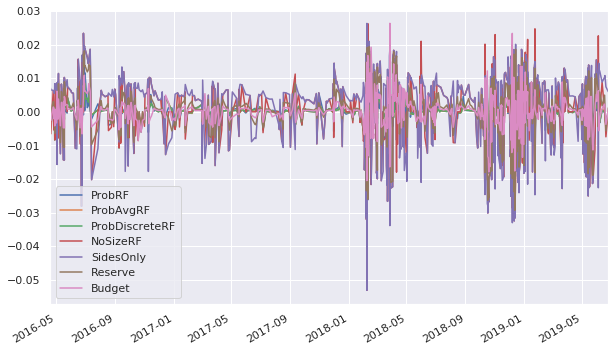

In [424]:
bet_ret.plot(figsize=(10,6))

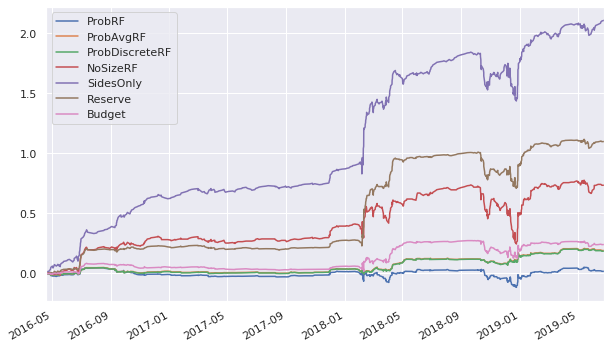

In [425]:
bet_ret.cumsum().plot(figsize=(10,6))

Text(0.5, 1.0, 'Meta-Labeling vs. Primary Model Only (return)')

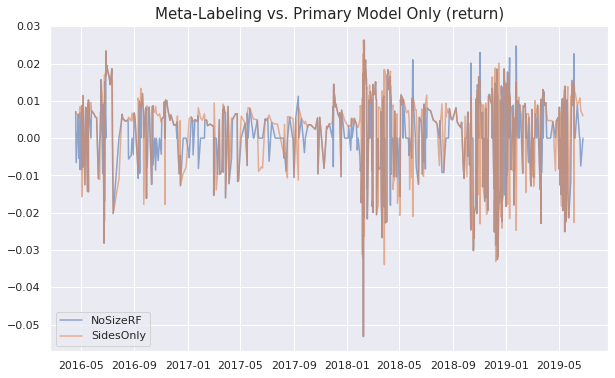

In [426]:
plt.figure(figsize=(10,6))
plt.plot(bet_ret[['NoSizeRF','SidesOnly']], alpha=0.6)
plt.legend(['NoSizeRF','SidesOnly'])
plt.title('Meta-Labeling vs. Primary Model Only (return)', fontsize=15)

Text(0.5, 1.0, 'Meta-Labeling vs. Primary Model Only')

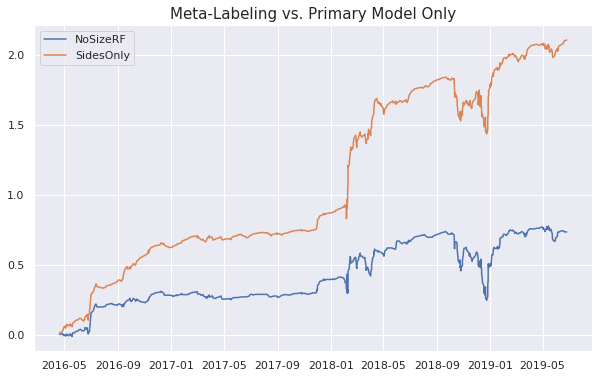

In [427]:
plt.figure(figsize=(10,6))
plt.plot(bet_ret[['NoSizeRF','SidesOnly']].cumsum())
plt.legend(['NoSizeRF','SidesOnly'])
plt.title('Meta-Labeling vs. Primary Model Only', fontsize=15)

Text(0.5, 1.0, 'Bet-Sizing vs. BinaryBet')

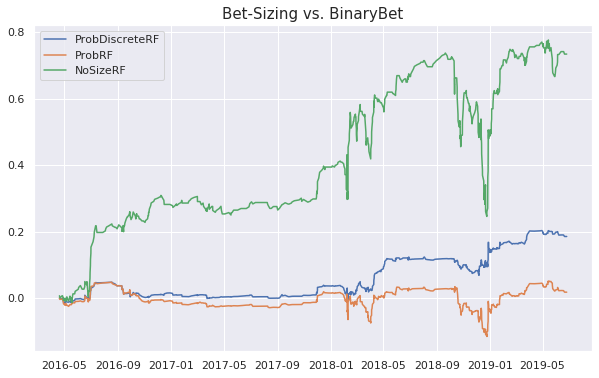

In [428]:
plt.figure(figsize=(10,6))
plt.plot(bet_ret[['ProbDiscreteRF','ProbRF','NoSizeRF']].cumsum())
plt.legend(['ProbDiscreteRF','ProbRF','NoSizeRF'])
plt.title('Bet-Sizing vs. BinaryBet', fontsize=15)

Text(0.5, 1.0, 'Bet-Sizing Types')

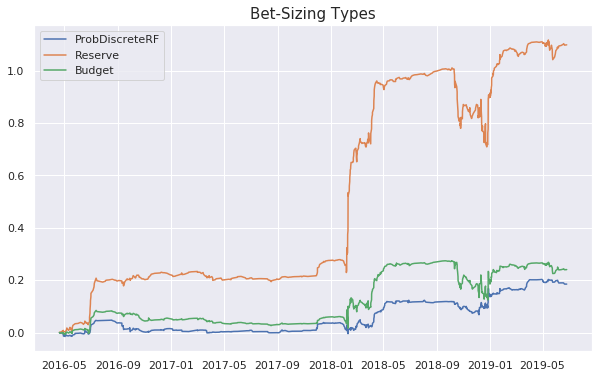

In [429]:
plt.figure(figsize=(10,6))
plt.plot(bet_ret[['ProbDiscreteRF','Reserve','Budget']].cumsum())
plt.legend(['ProbDiscreteRF','Reserve','Budget'])
plt.title('Bet-Sizing Types', fontsize=15)

### Sharpe Ratio

In [0]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [0]:
def sr(df):
    out = pd.DataFrame(index=['Ann Sharpe Ratio'])
    for c in df.columns:
        out[c] = (df[c].mean()/df[c].std()*(252**.5))
    return out

In [0]:
daily_ret = get_daily_returns(bet_ret)

In [410]:
daily_ret

ProbRF  ProbAvgRF  ProbDiscreteRF  ...  SidesOnly   Reserve    Budget
2016-04-20 -0.003948  -0.001959       -0.001964  ...   0.006546  0.000000 -0.002545
2016-04-21  0.000000   0.000000        0.000000  ...   0.000000  0.000000  0.000000
2016-04-22  0.000000   0.000000        0.000000  ...   0.000000  0.000000  0.000000
2016-04-25  0.001156   0.000592        0.000635  ...   0.006348  0.003061  0.001411
2016-04-26 -0.000715  -0.000344       -0.000302  ...   0.006050  0.002918  0.001344
...              ...        ...             ...  ...        ...       ...       ...
2019-06-19  0.000000   0.000000        0.000000  ...   0.000000  0.000000  0.000000
2019-06-20 -0.004171  -0.004171       -0.004095  ...   0.007445 -0.005682 -0.003722
2019-06-21  0.000000   0.000000        0.000000  ...   0.000000  0.000000  0.000000
2019-06-24  0.000000   0.000000        0.000000  ...   0.000000  0.000000  0.000000
2019-06-25 -0.000042  -0.000042        0.000000  ...   0.005974  0.001181  0.000664

[830 rows x 7 columns]

In [411]:
sr(daily_ret)

ProbRF  ProbAvgRF  ...   Reserve    Budget
Ann Sharpe Ratio  0.077868   1.009152  ...  1.810233  0.703903

[1 rows x 7 columns]

The Sharpe ratio associated with a binary outcome can be derived as

$$ \theta[p,n,\pi_-,\pi_+] = \frac{(\pi_+-\pi_-)p+\pi_-}{(\pi_+-\pi_-)\sqrt{p(1-p)}}\sqrt{n}
$$

where {𝜋−,𝜋+} determine the payoff from negative and positive outcomes, 𝑝 is the probability of a positive outcome, and 𝑛 is the number of outcomes per year

In [0]:
def sharperatio(pos,neg,p,n):
    sr = ((pos-neg)*p+neg)*(n**.5)/((pos-neg)*(p*(1-p))**0.5)
    return sr

In [0]:
###############

### Backtesting

In [414]:
!pip install -q pyfolio
import pyfolio as pf

     |████████████████████████████████| 92kB 9.5MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 


Bet sizing from meta-labeling

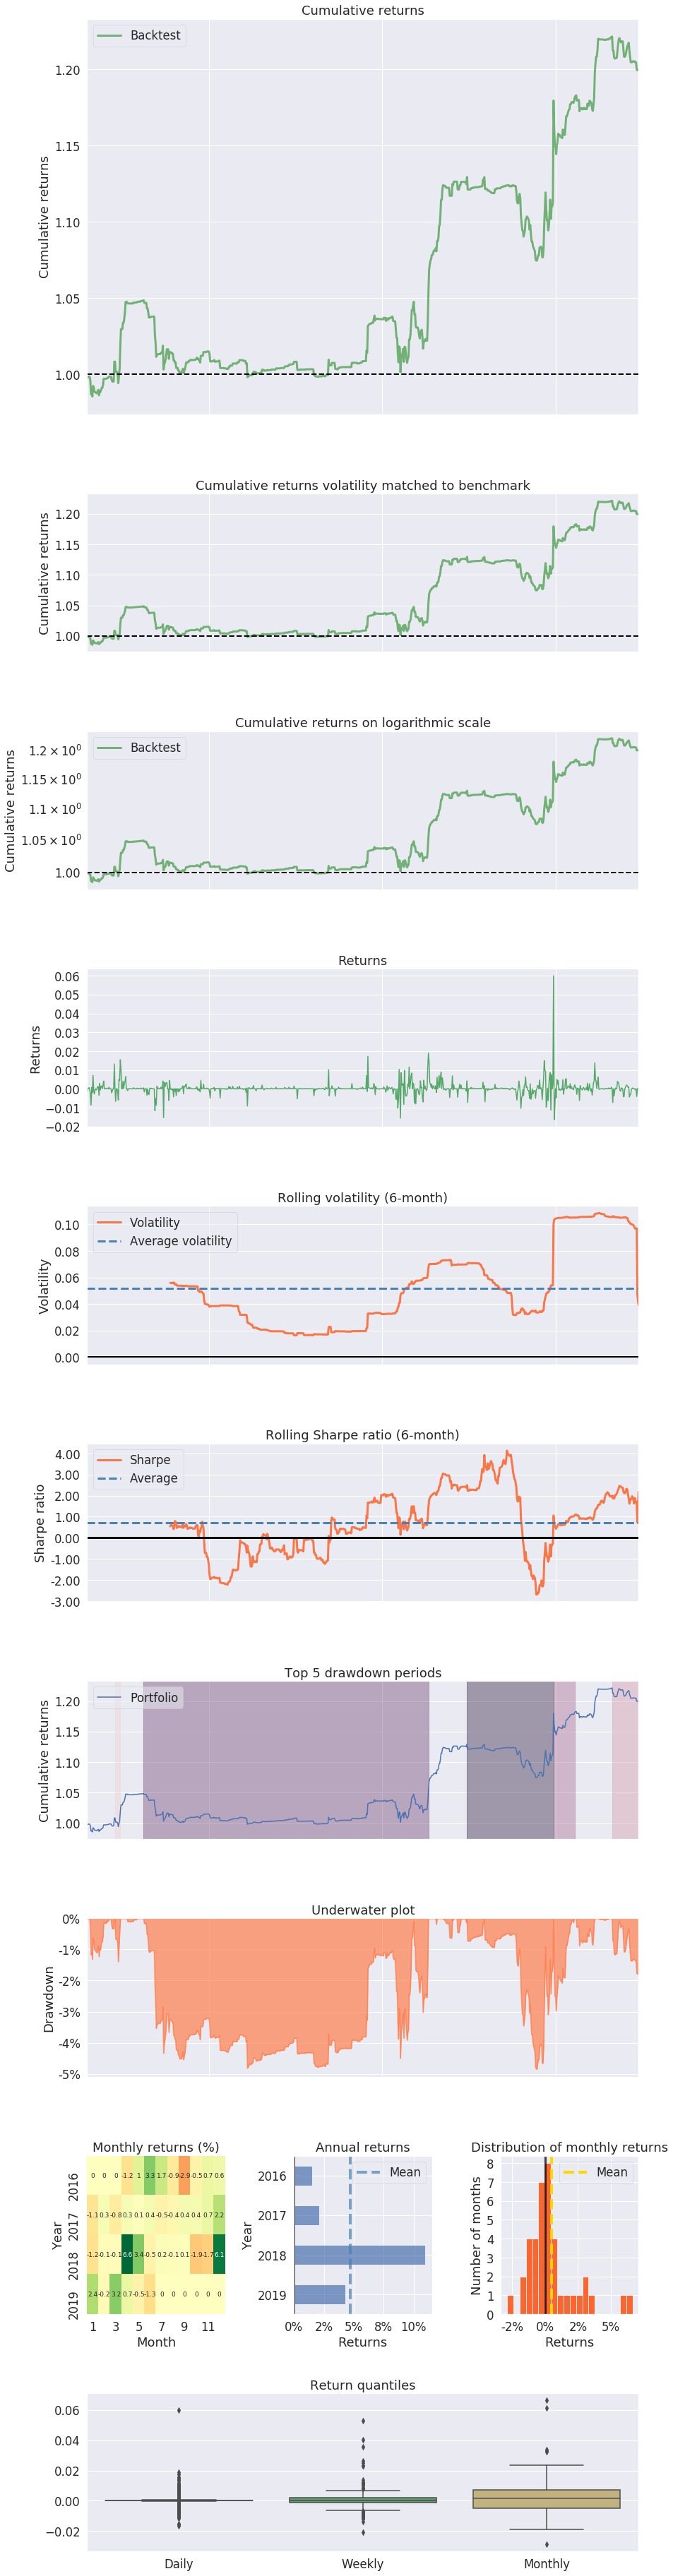

In [415]:
pf.create_returns_tear_sheet(daily_ret.ProbDiscreteRF, benchmark_rets=None)

Bet sizing reserving cash (fitted Gaussian mixture)

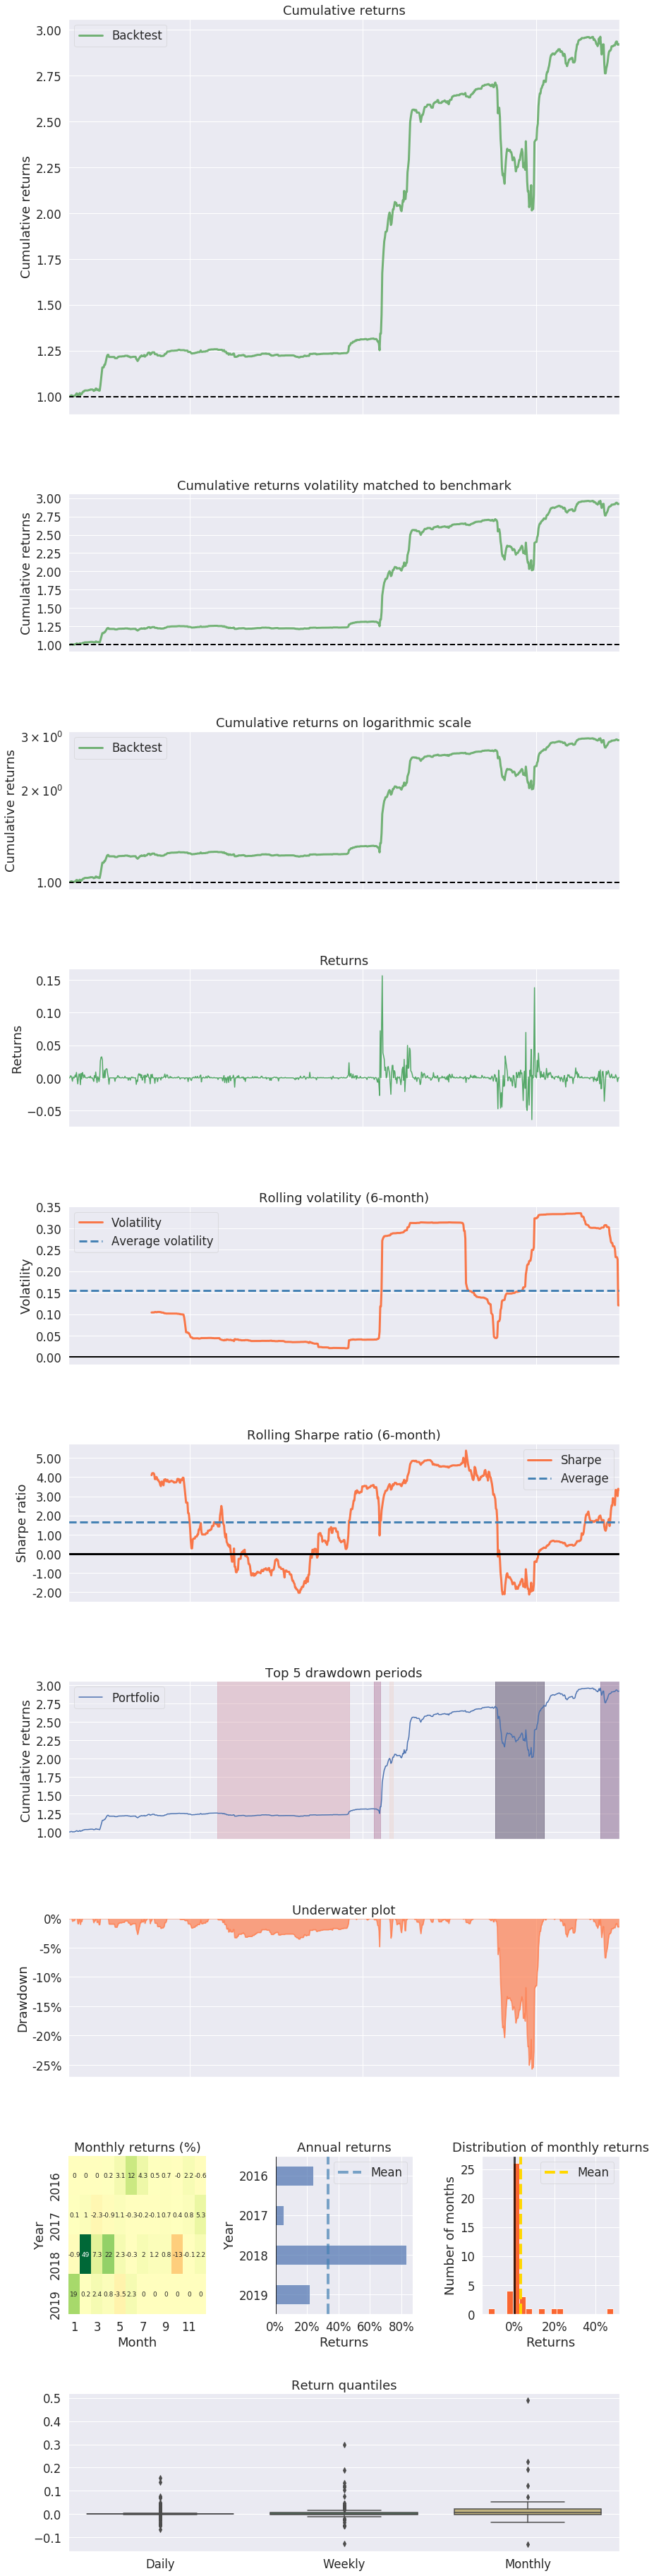

In [416]:
pf.create_returns_tear_sheet(daily_ret.Reserve, benchmark_rets=None)

Bet sizing with budgeting

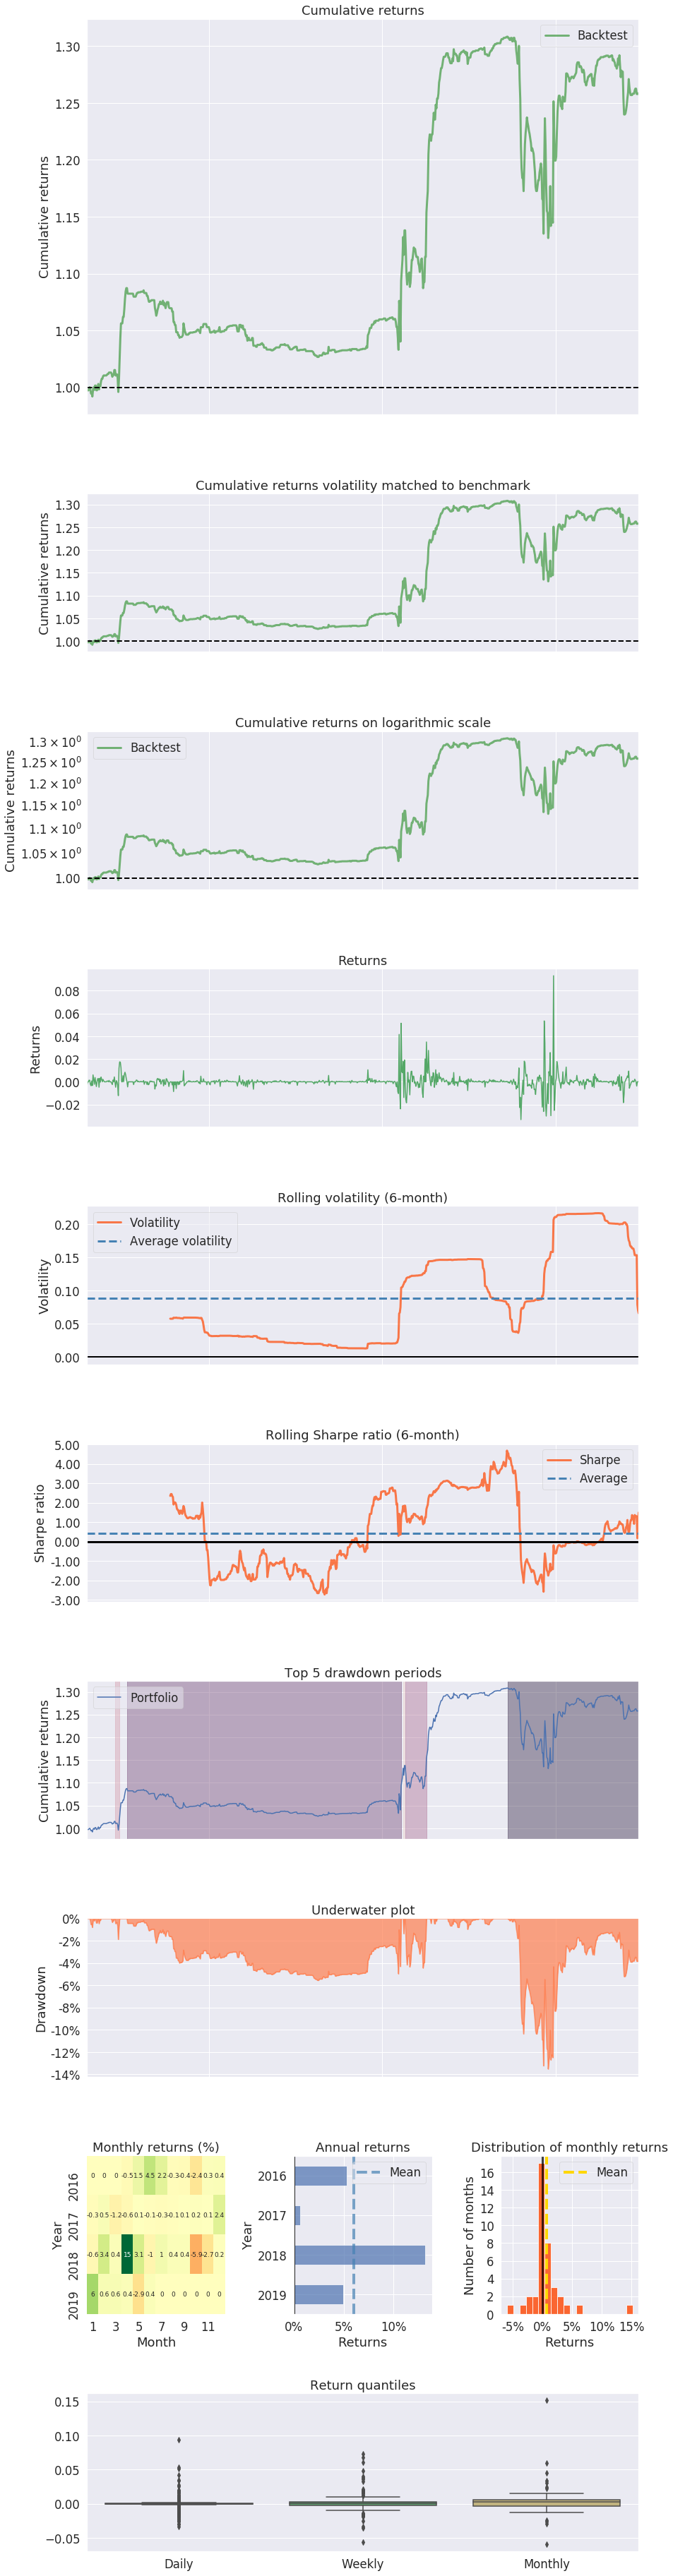

In [417]:
pf.create_returns_tear_sheet(daily_ret.Budget, benchmark_rets=None)

Meta-Labeling

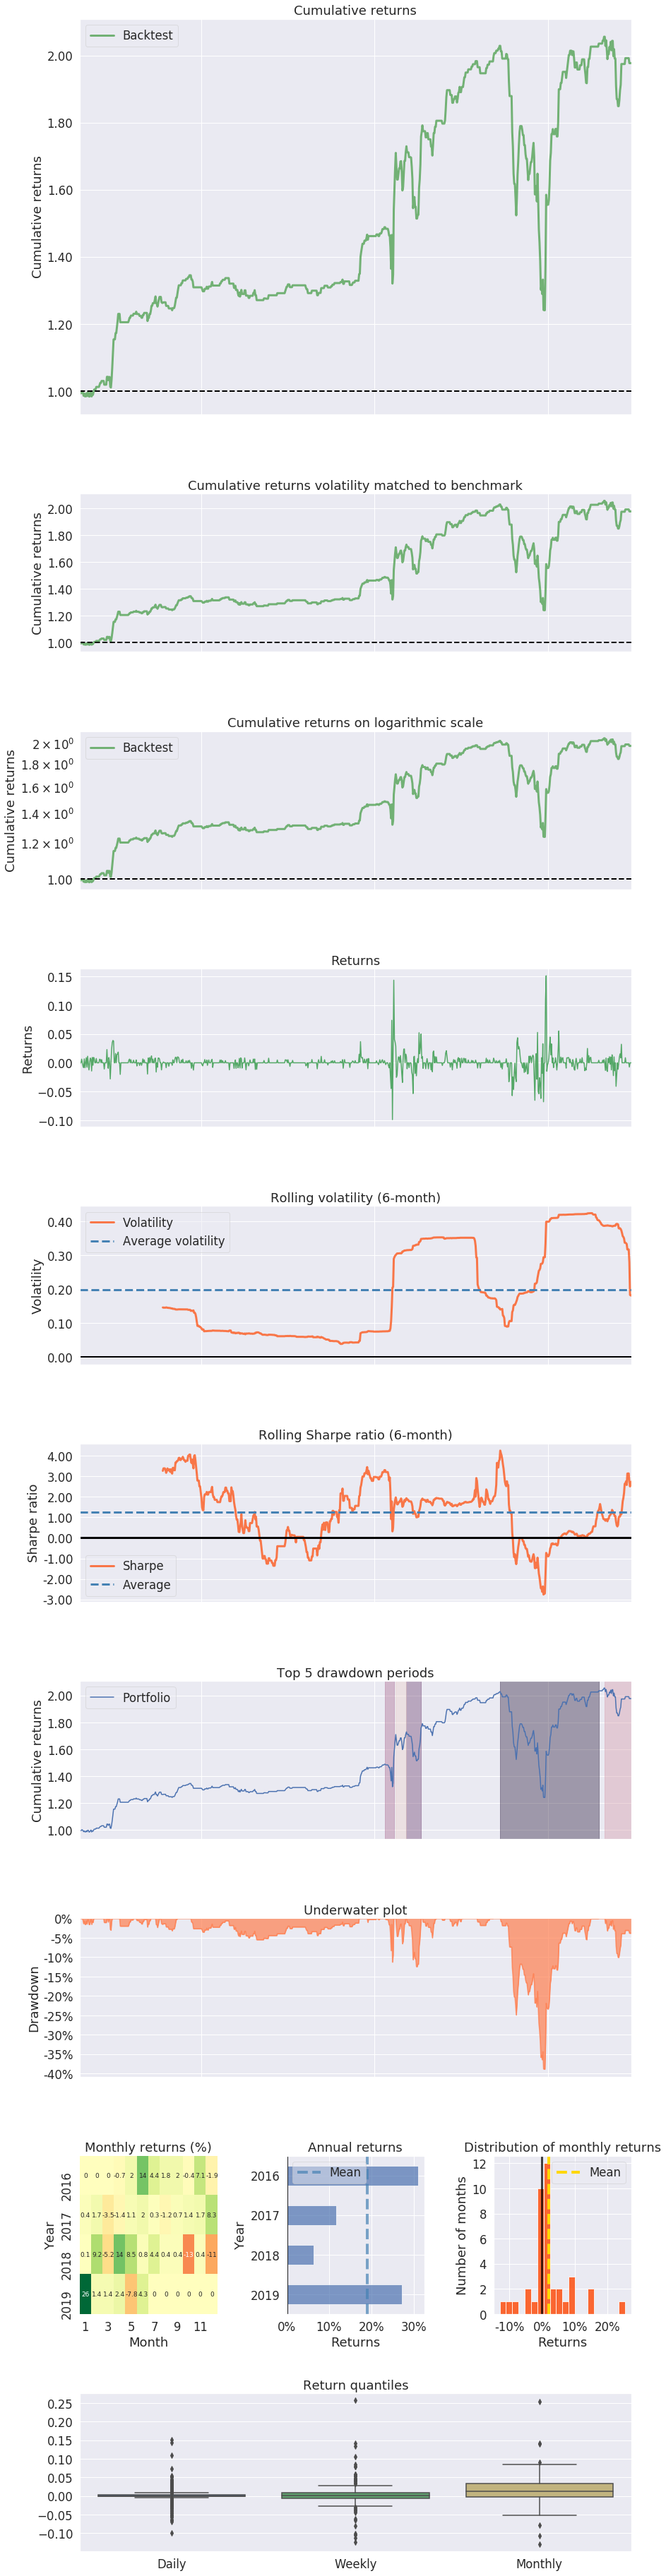

In [418]:
pf.create_returns_tear_sheet(daily_ret.NoSizeRF, benchmark_rets=None)

Primary model only

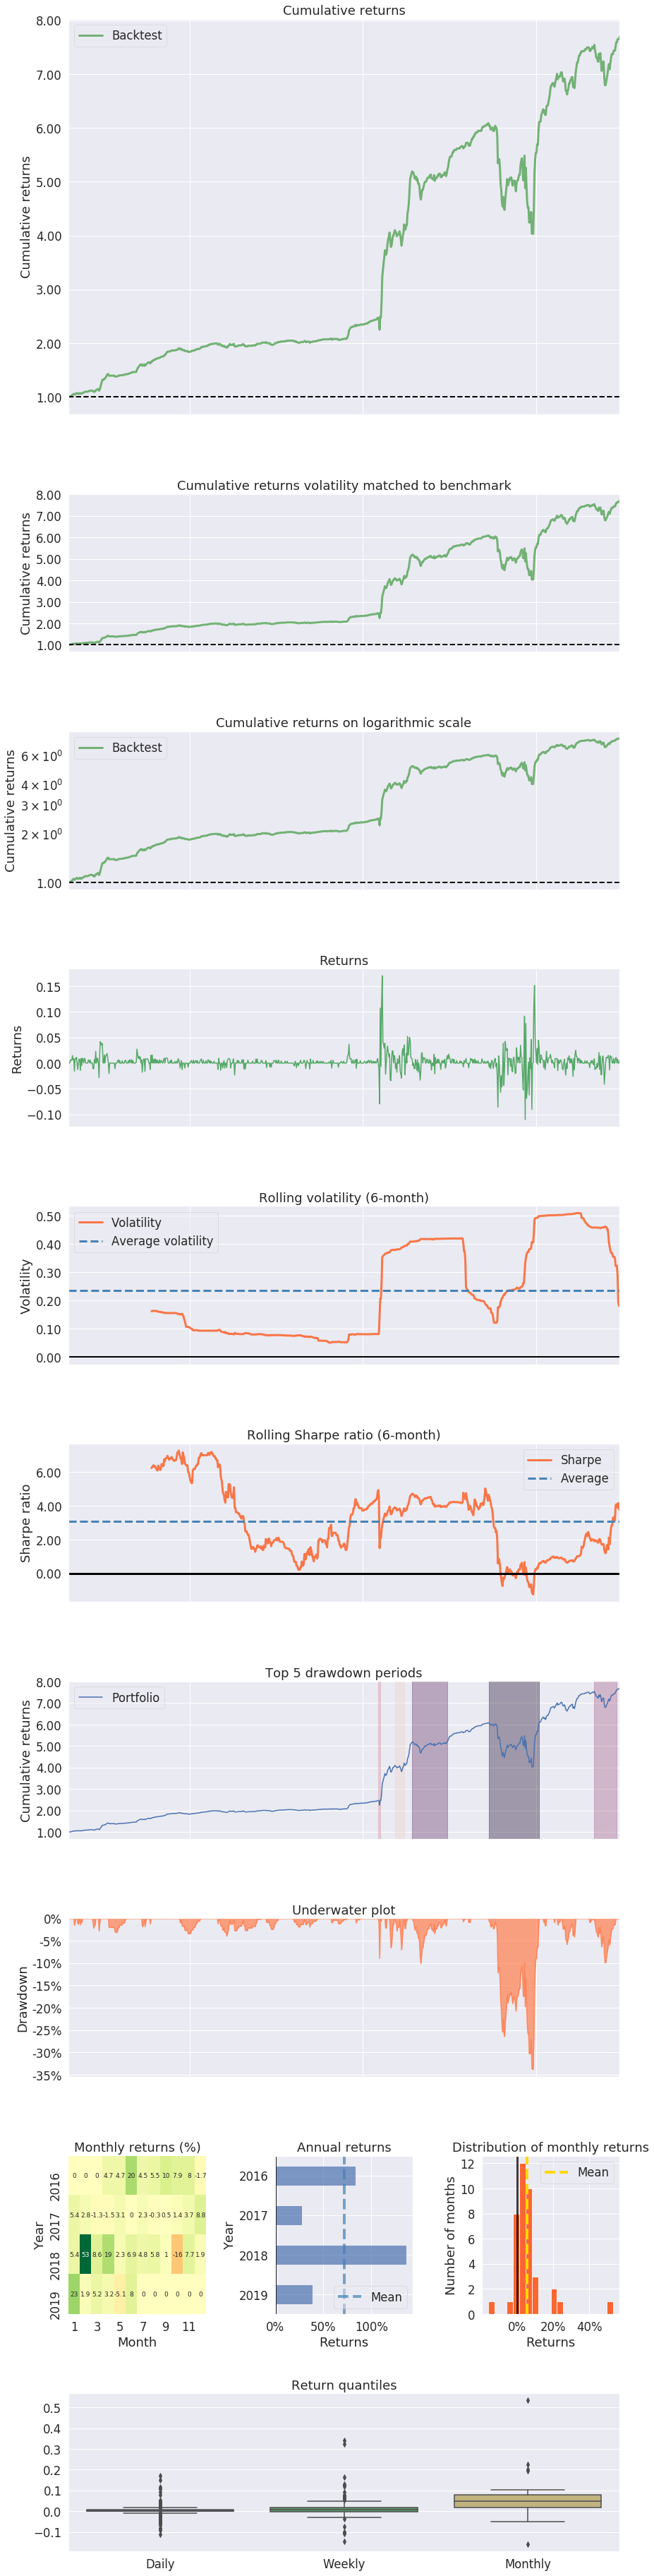

In [419]:
pf.create_returns_tear_sheet(daily_ret.SidesOnly, benchmark_rets=None)

In [0]:
bet_size_mean = (.25*bet_sizes.iloc[:,2] + .25*bet_sizes.iloc[:,3] + .5*bet_sizes.iloc[:,4])
bet_ret['Mean'] = bet_size_mean * data_size.ret
daily_ret['Mean'] = get_daily_returns(bet_ret['Mean'])

In [421]:
sr(bet_ret)

ProbRF  ProbAvgRF  ...    Budget      Mean
Ann Sharpe Ratio  0.084717   1.356418  ...  1.016395  2.072923

[1 rows x 8 columns]

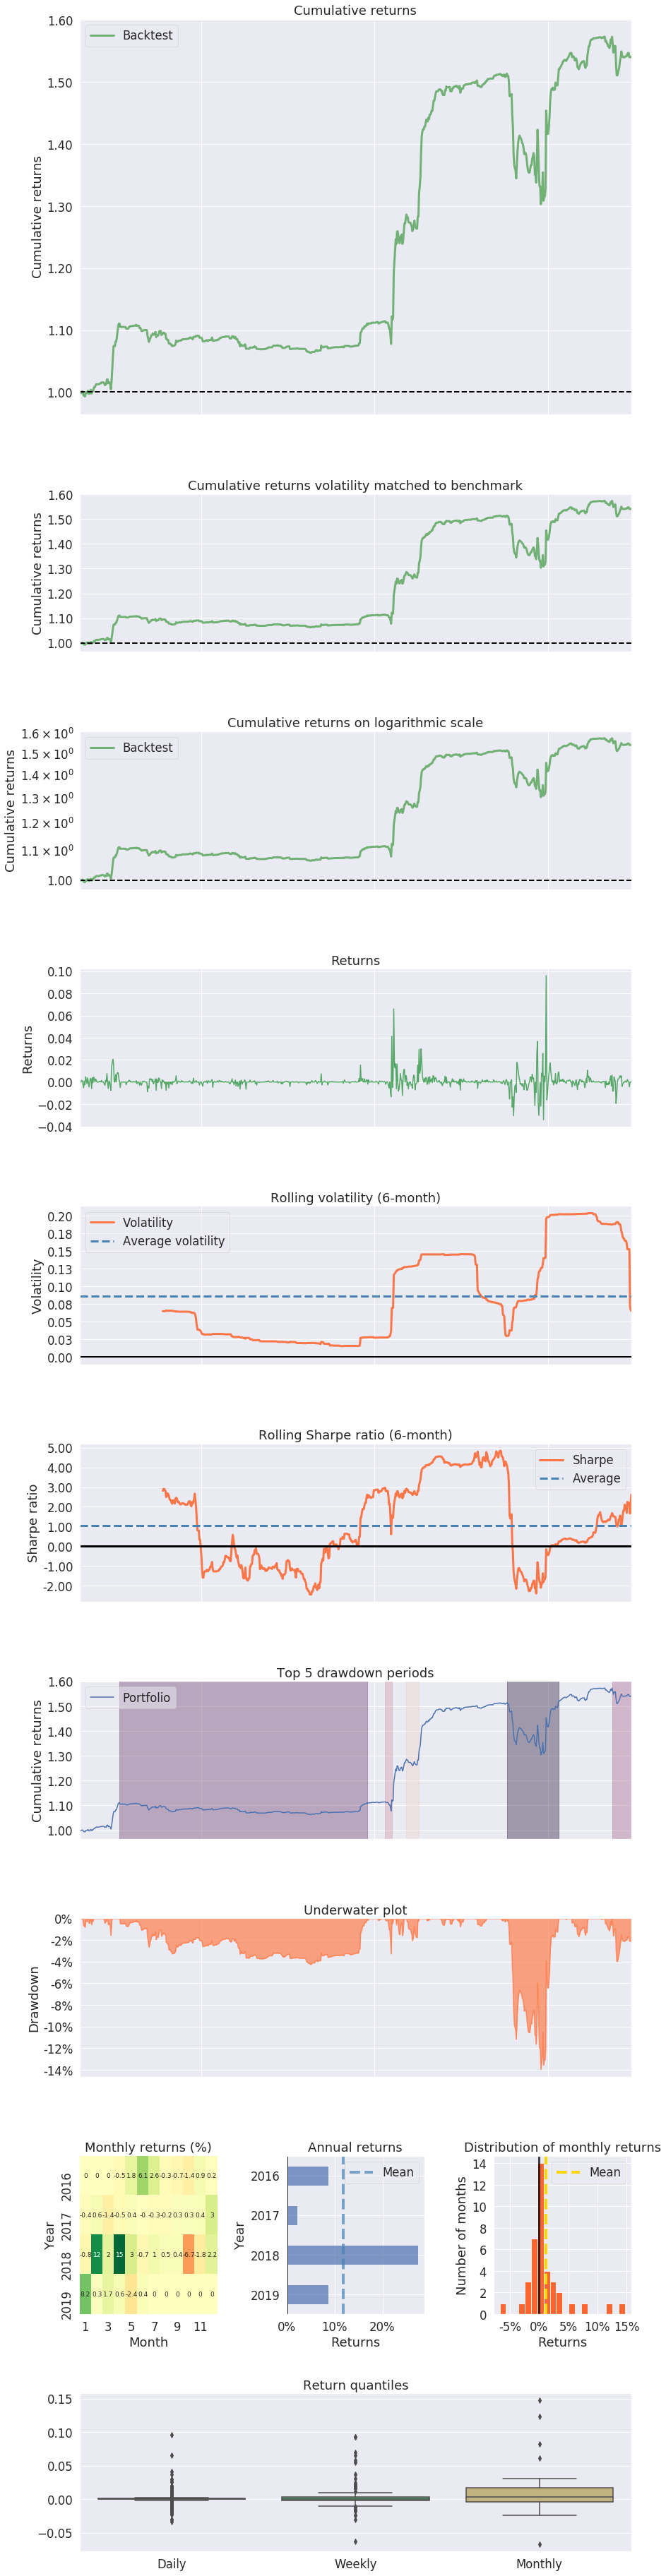

In [422]:
pf.create_returns_tear_sheet(daily_ret.Mean, benchmark_rets=None)

## Applying Deep learning or Reinforcement learning

get probabilities from Q-value - Softmax

# REFERENCE

Marcos Lopez de Prado. Advances in Financial Machine Learning. Wiley, 2018

https://github.com/hudson-and-thames/research

Marcos Lopez de Prado and Matthew D. Foreman. “A mixture of Gaussians approach to mathematical portfolio oversight: the EF3M algorithm”. In: Quantitative Finance14.5 (2014), pp. 913–930.

Yakup Kara
, Melek Acar Boyacioglu 
, Ömer Kaan Baykan. "Predicting direction of stock price index movement using artificial neural
networks and support vector machines: The sample of the Istanbul Stock Exchange"


https://scikit-learn.org/stable/modules/svm.html#scores-and-probabilities

s/o to mlfinlab, ta, pyfolio